In [1]:
%pylab
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform, cdist

import wfg

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(5,5)

In [3]:
def notDominated(X):
    """
    Return a Boolean vector with as many rows as X indicating whether each
    row of X is not dominated by the other elements of X; ie, whether each
    row is Pareto optimal for X.
    """
    y = zeros(X.shape[0], dtype='bool')
    for n in range(X.shape[0]):
        # Find the number of times on each row where X[i,j] >= X[n,j];
        # y[n] is not dominated if this is bigger than for every row
        y[n] = min(sum(X >= X[n,:], 1)) > 0
    return y

In [6]:
N = 10000
M = 3                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2

f = np.zeros((N, M))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    f[n,:] = func(z, k, M)
pi = notDominated(f)
di = np.invert(pi)

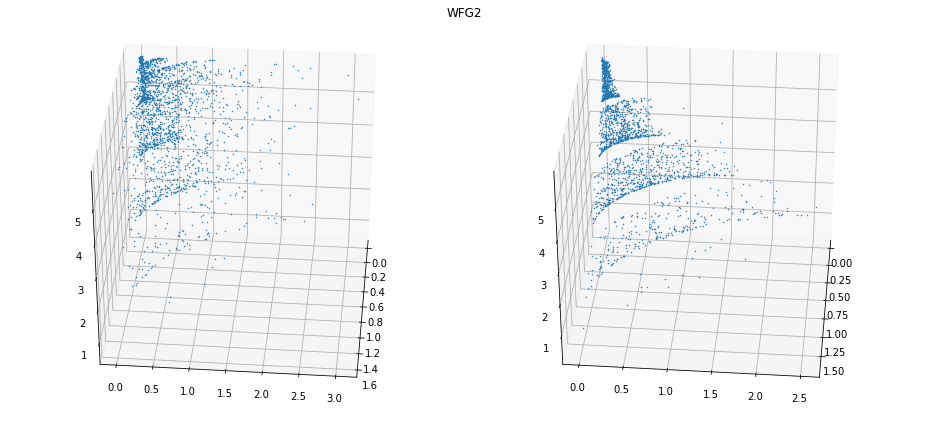

In [7]:
fig = plt.figure(figsize=[13, 6])
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2, projection='3d')

ax0.plot(*f[:2000].T, '.', ms=1)
ax1.plot(*f[pi][:2000].T, '.', ms=1)
ax0.view_init(elev=35, azim=5)
ax1.view_init(elev=35, azim=5)
plt.suptitle(func.__name__)
plt.tight_layout()

In [10]:
M = 100  # Number of points required

f2 = f[pi].copy()
in_pool = f2[:M,:] 
out_pool = f2[M:,:]
in_pool2 = in_pool.copy()

D = squareform(pdist(in_pool))    # distance matrix
np.fill_diagonal(D, np.nan)
nnd_pool = nanmin(D, axis=0)

for query in out_pool:
    query_dist = cdist(query[np.newaxis,:], in_pool)
    nnd_query = np.nanmin(query_dist)
    if nnd_query > np.nanmin(nnd_pool):    # if the query is 'better' than worst in current pool
        # do substitution 
        sub_index = np.nanargmin(nnd_pool)
        in_pool[sub_index,:] = query[:]
        D[sub_index,:] = nnd_pool[:]
        D[sub_index, sub_index] = np.nan
        nnd_pool[sub_index] = np.nanmin(query_dist) 
    elif False:
        # is query nearest neighbour less than median
        above_med_inds = np.where(nnd_pool>median(nnd_pool))[0]
        # would it reduce the nn distance for these?
        d_q_med = cdist(query[np.newaxis,:], in_pool[above_med_inds])
        ii = np.where(d_q_med<nnd_pool[above_med_inds])[1]
        inds = above_med_inds[ii] 
        if inds.size>0:
            # do substitution
            sub_index = inds[0]
            in_pool[sub_index,:] = query[:]
            D[sub_index,:] = nnd_pool[:]
            D[sub_index, sub_index] = np.nan
            nnd_pool[sub_index] = np.nanmin(query_dist) 

In [22]:
M = 100  # Number of points required

f3 = f[pi].copy()
in_pool2 = f3[:M,:] 
out_pool2 = f3[M:,:]

D = squareform(pdist(in_pool2))    # distance matrix
np.fill_diagonal(D, np.nan)
nnd_pool2 = nanmin(D, axis=0)

for query in out_pool2:
    query_dist = cdist(query[np.newaxis,:], in_pool2)
    nnd_query = np.nanmin(query_dist)
    if nnd_query > np.nanmin(nnd_pool2):    # if the query is 'better' than worst in current pool2
        # do substitution 
        sub_index = np.nanargmin(nnd_pool2)
        in_pool2[sub_index,:] = query[:]
        D[sub_index,:] = nnd_pool2[:]
        D[sub_index, sub_index] = np.nan
        nnd_pool2[sub_index] = np.nanmin(query_dist) 
    elif nnd_query:
        # get points with nn distances greater than median
        above_med_inds = np.where(nnd_pool2>median(nnd_pool2))[0]
        # would it reduce the nn distance for these?
        d_q_med = cdist(query[np.newaxis,:], in_pool2[above_med_inds])
        ii = np.where(d_q_med<nnd_pool2[above_med_inds])[1]
        inds = above_med_inds[ii] 
        if inds.size>0:
            # do substitution
            sub_index = inds[0]
            in_pool2[sub_index,:] = query[:]
            D[sub_index,:] = nnd_pool2[:]
            D[sub_index, sub_index] = np.nan
            nnd_pool2[sub_index] = np.nanmin(query_dist) 

In [23]:
print(in_pool.shape)
print(in_pool2.shape)

(100, 3)
(100, 3)


Text(0.5, 0.98, 'WFG2')

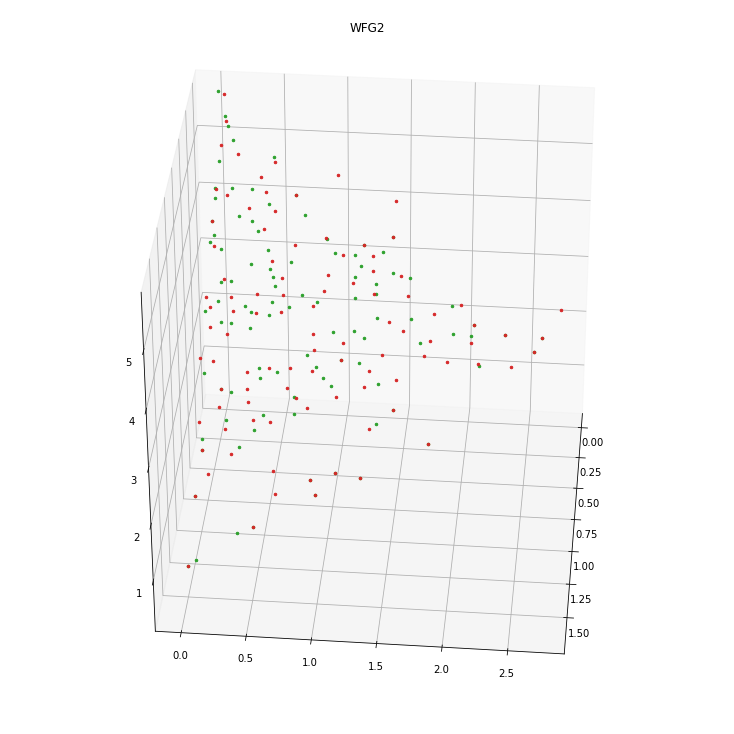

In [25]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
# ax.plot(*f[pi][:in_pool.shape[0]].T, '.', ms=5, c="C0")
ax.plot(*in_pool2.T, '.', ms=5, c="C2")
ax.plot(*in_pool.T, '.', ms=5, c="C3")
ax.view_init(elev=35, azim=5)
plt.suptitle(func.__name__)

# fig, ax = plt.subplots(3, 1, sharex=True)
# for a, z in zip(ax, (mind, medd, maxd)):
#     a.plot(z)

In [36]:
np.all(f[pi][:2000]==in_pool)

False

(array([[   0.,    0.,    8., 1878.,  114.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    9.,   27., 1855.,  106.,    3.,    0.,    0.,    0.,
            0.],
        [   7.,   20.,   46., 1706.,   43.,   58.,   44.,   35.,   27.,
           14.]]),
 array([-3.08763831e+00, -2.31460566e+00, -1.54157301e+00, -7.68540360e-01,
         4.49228858e-03,  7.77524938e-01,  1.55055759e+00,  2.32359024e+00,
         3.09662288e+00,  3.86965553e+00,  4.64268818e+00]),
 <a list of 3 Lists of Patches objects>)

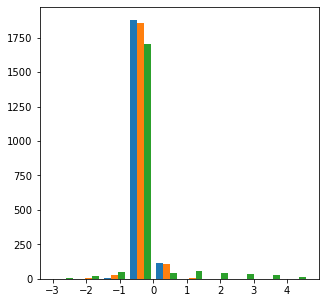

In [39]:
hist(f[pi][:2000]-in_pool)